In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sportran as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from scipy.interpolate import CubicSpline, interp1d
def model_scalar(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

n = 2
def model_wishart_(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [np.zeros_like(y01), y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    # return interp1d(xx, yy)) 
    return CubicSpline(xx, yy) #, bc_type = 'clamped')

import numpy as np
from scipy.interpolate import CubicSpline

def model_wishart(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    upper_triangle_indices = np.triu_indices(N)
    y_elements = y.reshape(len(upper_triangle_indices[0]), l)
    
    yy = np.zeros((l, N, N))
    for k, (i, j) in enumerate(zip(*upper_triangle_indices)):
        yy[:, j, i] = y_elements[k]
    
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

def mini_model_w(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    
    # y.shape should be l*N**2
    yy = y.reshape(l, N**2)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

def mini_model_w_real(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    yy = y.reshape(l, N*(N+1)//2)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)


In [14]:
dc=np.load('data/bayesian/CsF/dc_minimal.npy', allow_pickle = True).item()

In [393]:
def split_bl(array):
    s = array.shape[0]//2
    return np.hstack([array[:s], array[s:]])

In [473]:
flux = st.HeatCurrent(
    [
        # dc['heat_flux'],
        # dc['electric_flux']
        split_bl(dc['heat_flux']),
        split_bl(dc['electric_flux'])
    ],
    DT_FS=1,
    TEMPERATURE=dc['Temperature'],
    VOLUME=dc['Volume'],
    UNITS='metal'
    )
flux_resample=flux.resample(fstar_THz=20)
flux_resample.filter_psd(0.5)

Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2001
 min(PSD)          (pre-filter&sample) =      0.00208
 min(PSD)         (post-filter&sample) =   1856.32621
 % of original PSD Power f<f* (pre-filter&sample)  = 99.365 %
 fPSD not calculated before resampling
 -----------------------------------------------------



In [466]:
# to check the NLL estimate
flux_c = st.ElectricCurrent(
    split_bl(dc['electric_flux']),
    DT_FS=1,
    TEMPERATURE=dc['Temperature'],
    VOLUME=dc['Volume'],
    UNITS='metal'
    )
flux_resample = flux_c.resample(fstar_THz=20)
flux_resample.filter_psd(0.5)
flux_resample.cepstral_analysis()

Using single component code.
Using single component code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2001
 min(PSD)          (pre-filter&sample) =      0.10953
 min(PSD)         (post-filter&sample) =    417.00365
 % of original PSD Power f<f* (pre-filter&sample)  = 99.936 %
 fPSD not calculated before resampling
 -----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  cutoffK = (P*-1) = 7  (auto, AIC_Kmin = 7, corr_factor =  1.0)
  L_0*   =          13.162604 +/-   0.036877
  S_0*   =      62059

# Diagonal (thermal)

In [474]:
flux_resample.maxlike_estimate(
    model_scalar, 
    # n_parameters = 'AIC',
    16, 
    likelihood='chisquare', 
    solver = 'BFGS',
    minimize_kwargs = {
        'tol': 1e-10,
        'jac': '3-point',
        'options': {
            'disp': True, 
            'gtol': 1e-4, 
            'maxiter': 500, 
            'eps': 1e-9,
            }
        },
    # ext_guess=flux_resample.cepf.psd[::len(flux_resample.cepf.psd)//16][:-1]

)
flux_resample.maxlike.optimizer_res

MaxLikeFilter Initialization
Maximum-likelihood estimation with n_parameters = 16
Spline nodes are equispaced from 0 to the Nyquist frequency.
Optimization terminated successfully.
         Current function value: -7835.506135
         Iterations: 368
         Function evaluations: 12639
         Gradient evaluations: 383
The BFGS solver provides Hessian. Covariance matrix estimated through Laplace approximation.
factor 1
-----------------------------------------------------
  MAXIMUM LIKELIHOOD ESTIMATION
-----------------------------------------------------
  Fixed n_parameters = 16
  kappa* =           0.236849 +/-   0.007326  W/m/K
-----------------------------------------------------



  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -7835.506135395672
        x: [ 7.677e+05  5.450e+05 ...  5.844e+03  3.143e+03]
      nit: 368
      jac: [ 5.638e-05 -3.448e-06 ... -5.250e-05 -4.946e-05]
 hess_inv: [[ 1.410e+08  2.437e+08 ... -9.078e+04  6.190e+05]
            [ 2.437e+08  4.259e+08 ... -1.448e+05  9.898e+05]
            ...
            [-9.078e+04 -1.448e+05 ...  6.175e+04 -4.884e+04]
            [ 6.190e+05  9.898e+05 ... -4.884e+04  2.207e+05]]
     nfev: 12639
     njev: 383

In [475]:
flux_resample.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  cutoffK = (P*-1) = 7  (auto, AIC_Kmin = 7, corr_factor =  1.0)
  L_0*   =          13.603064 +/-   0.040742
  S_0*   =     1000687.651713 +/- 40770.158812
-----------------------------------------------------
  kappa* =           0.308721 +/-   0.012578  W/m/K
-----------------------------------------------------



In [476]:
np.shape(flux_resample.cepf.psd[::len(flux_resample.cepf.psd)//16]*flux_resample.KAPPA_SCALE/2)

(17,)

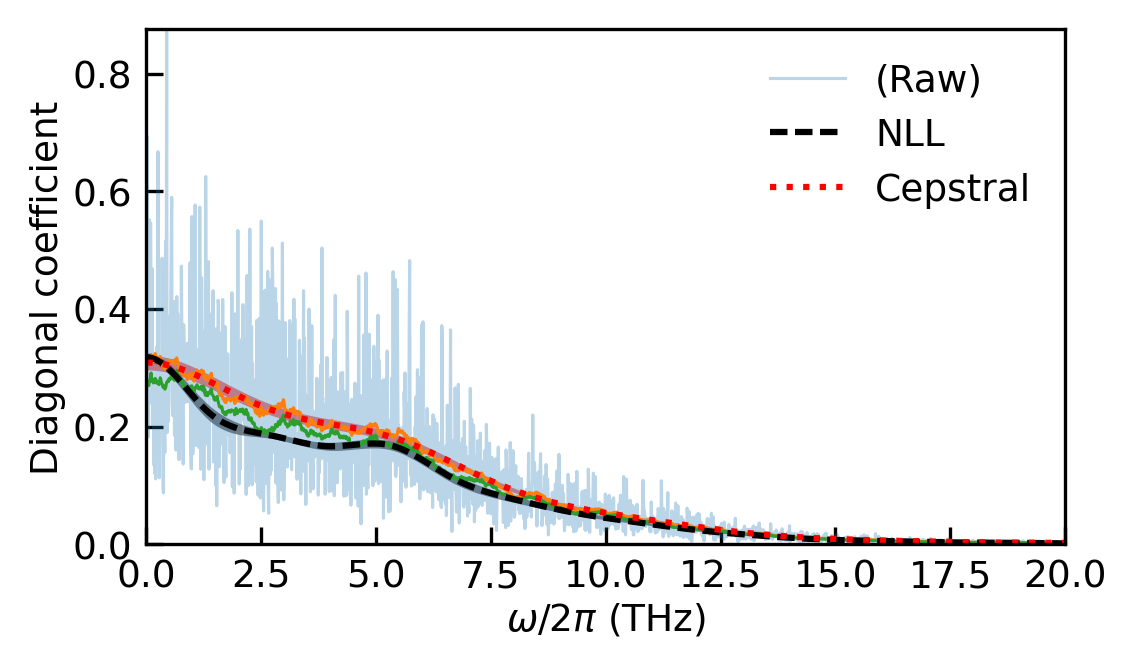

In [493]:
data_chisquare = flux_resample.psd
estimate = flux_resample.NLL_mean
estimate_std = flux_resample.NLL_std

ip = 0
addaxes = []

N = data_chisquare.shape[-1]
fs = plt.rcParams['figure.figsize']

fig, ax = plt.subplots()

pl, = ax.plot(flux_resample.freqs_THz, 
                flux_resample.psd*flux_resample.KAPPA_SCALE/2, 
                alpha = 0.3, 
                label = f'(Raw)',
        )

from sportran.md.tools.filter import runavefilter
ax.plot(flux_resample.freqs_THz, runavefilter(flux_resample.psd, 50)*flux_resample.KAPPA_SCALE/2)
ax.plot(flux_resample.freqs_THz, np.exp(runavefilter(np.log(flux_resample.psd), 50))*flux_resample.KAPPA_SCALE/2)

# ax.plot(flux_resample.freqs_THz, 
#         flux_resample.fpsd*flux_resample.KAPPA_SCALE/2, 
#         alpha = 1, 
#         label = f'(MA)', 
#         lw = 1.5,
#         color = pl.get_color()
#         )

ymin, ymax = ax.get_ylim()

x, y = flux_resample.freqs_THz, estimate*flux_resample.KAPPA_SCALE/2 / (np.sqrt(5)/3)
y_std = estimate_std*flux_resample.KAPPA_SCALE/2 
ax.plot(x, 
        y, 
        color = 'k',
        lw = 1.5,
        label = 'NLL',
        ls = '--')
ax.fill_between(x, 
                y-y_std, 
                y+y_std, 
                color = 'k', 
                alpha = 0.5)

x, y = flux_resample.freqs_THz, flux_resample.cepf.psd*flux_resample.KAPPA_SCALE/2
y_std = flux_resample.kappa_std/flux_resample.kappa * y
ax.plot(x, 
        y, 
        color = 'r',
        lw = 1.5,
        label = 'Cepstral',
        ls = ':')        
ax.fill_between(x, 
                y-y_std, 
                y+y_std, 
                color = 'r', 
                alpha = 0.5)
        
ax.set_ylim(0,ymax)
ax.set_xlabel('$\omega/2\pi$ (THz)')
ax.set_ylabel('Diagonal coefficient')

ax.legend()
# ax.set_xlim(0,1)

fig.tight_layout()

In [487]:
1/ (flux_resample.cepf.tau_cutoffK / flux_resample.maxlike.NLL_mean[0])

0.7671919546429262

In [488]:
flux_resample.N_EQUIV_COMPONENTS, flux_resample.N_CURRENTS

(6, 2)

In [489]:
flux_resample.ndf_chi

5

In [490]:
np.sqrt(5)/3

0.7453559924999299

In [ ]:
self.N_EQUIV_COMPONENTS - self.N_CURRENTS + 1

In [417]:
flux_resample.N_EQUIV_COMPONENTS - flux_resample.N_CURRENTS + 1

6

In [140]:
factor = (
                np.sqrt(flux_resample.N_EQUIV_COMPONENTS) / flux_resample.N_CURRENTS / np.sqrt(2)
            )
print(flux_resample.N_EQUIV_COMPONENTS, flux_resample.N_CURRENTS, factor)

3 2 0.6123724356957945


In [141]:
factor/np.sqrt(3/2)

0.5

# Off-diagonal (Seebeck)

To fix: cepstral estimate of the other parameters is missing

In [ ]:
flux_resample.maxlike_estimate(
    model_scalar, 
    n_parameters=9, 
    likelihood='variance-gamma', 
    solver = 'BFGS',
    minimize_kwargs = {
        'tol': 1e-6,
        'jac': '3-point',
        'options': {'disp': True, 'gtol': 1e-3, 'maxiter': 500, 'eps': 1e-5}
    }
)
flux_resample.maxlike.optimizer_res

In [ ]:
ase.units._e

In [ ]:
np.sqrt(ase.units._amu*1e-10/ase.units._e) * 1e10

# Wishart

In [46]:
flux_resample.maxlike_estimate(
    lambda x, y: mini_model_w_real(x, y, 2), 
    np.arange(5, 7), 
    # 5,
    solver = 'BFGS',
    minimize_kwargs = {
        'tol': 1e-8,
        'jac': '3-point',
        'options': {
            'disp': True, 
            'gtol': 1e-4, 
            'maxiter': 500, 
            'eps': 1e-6
            },
    }
)

MaxLikeFilter Initialization
Maximum-likelihood estimation with n_parameters = [5 6]
Optimal number of parameters between 5 and 6 chosen by AIC
n_parameters = 5
Spline nodes are equispaced from 0 to the Nyquist frequency.
Optimization terminated successfully.
         Current function value: 315290.878811
         Iterations: 99
         Function evaluations: 3472
         Gradient evaluations: 112
AIC: -315295.87881098286; Steps since last AIC update: 0
n_parameters = 6
Spline nodes are equispaced from 0 to the Nyquist frequency.
Optimization terminated successfully.
         Current function value: 314963.154126
         Iterations: 116
         Function evaluations: 4440
         Gradient evaluations: 120
AIC: -314969.1541260746; Steps since last AIC update: 0
-----------------------------------------------------
  MAXIMUM LIKELIHOOD ESTIMATION
-----------------------------------------------------
  Fixed n_parameters = 6
  S_{00} =      972594.670523 +/- 30925.620794
  S_{01} =    

In [42]:
import ase
def scale_jc(units='metal'):
    if units == 'metal' or units == 'gpumd':
        Ang_to_m = 1/ase.units.m
        ps_to_s = 1e-12
        return ase.units._e * Ang_to_m / ps_to_s
    else:
        raise NotImplementedError(f"Units `{units}` not implemented")
    
def scale_jq(units='metal'):
    if units == 'metal':
        eV_to_J = 1/ase.units.J
        Ang_to_m = 1/ase.units.m
        ps_to_s = 1e-12
        return eV_to_J * Ang_to_m / ps_to_s
    elif units == 'gpumd':
        return ase.units._e**(3/2) / ase.units._amu
    
eV_to_J = 1/ase.units.J
Ang_to_m = 1/ase.units.m
ps_to_s = 1e-12
T = flux_resample.TEMPERATURE
V = flux_resample.VOLUME * Ang_to_m**3

kappa_scale = 1/ase.units._k/V/T**2 * scale_jq()**2 * ps_to_s/1000
sigma_scale = 1/ase.units._k/V/T * scale_jc()**2 * ps_to_s/1000
mixed_scale = 1/ase.units._k/V/T * scale_jc()*scale_jq() * ps_to_s/1000

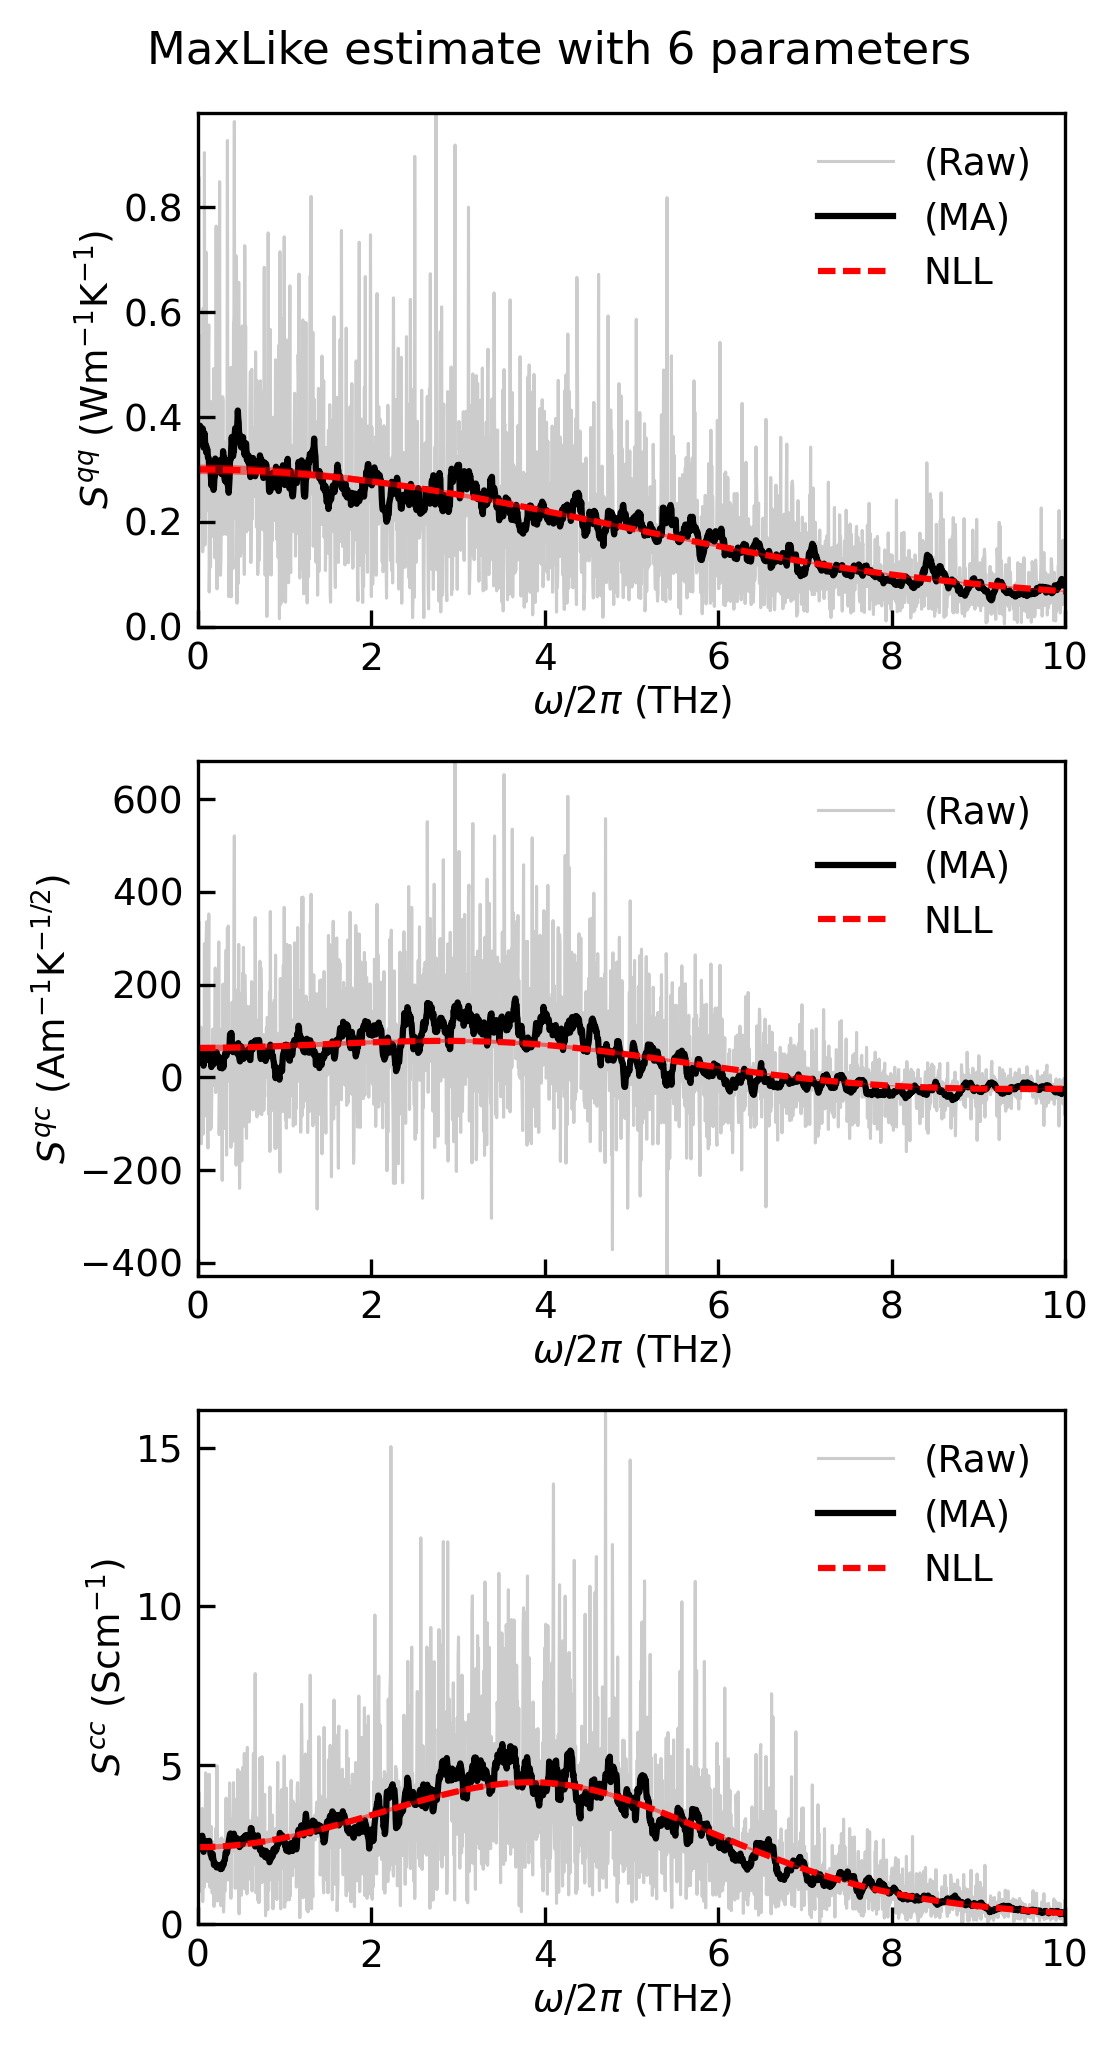

In [44]:
unit_factors = {
        (0,0): 0.5*kappa_scale,
        (0,1): 0.5*mixed_scale,
        (1,1): 0.5*sigma_scale/100,
}

unit_symbol = {
        (0,0): r'$\mathrm{Wm^{-1}K^{-1}}$',
        (0,1): r'$\mathrm{Am^{-1}K^{-1/2}}$',
        (1,1): r'$\mathrm{Scm^{-1}}$',
}

quantity = {
        0: 'q',
        1: 'c',
}

data_wishart = flux_resample.cospectrum.real.transpose((2,0,1)) / flux_resample.N_EQUIV_COMPONENTS
fdata_wishart = flux_resample.fcospectrum.real.transpose((2,0,1)) / flux_resample.N_EQUIV_COMPONENTS
estimate = flux_resample.NLL_mean
estimate_std = flux_resample.NLL_std

ip = 0
addaxes = []

N = data_wishart.shape[-1]
fs = plt.rcParams['figure.figsize']

fig, axes = plt.subplots(nrows = N*(N+1)//2, ncols = 1, figsize = (fs[0], 3*fs[1]))

for ax, i, j in zip(axes, *np.triu_indices(2)):

        unit_factor = unit_factors[i,j]

        pl, = ax.plot(
                flux_resample.freqs_THz, 
                data_wishart[:, i, j]*unit_factor, 
                alpha = 0.2, 
                label = f'(Raw)',
                zorder = 0,
                color = 'k',
                )

        ax.plot(
                flux_resample.freqs_THz, 
                # pd.Series(data_wishart[:, i, j]).rolling(window=50).mean()*flux_resample.KAPPA_SCALE/2, 
                fdata_wishart[:, i, j]*unit_factor * flux_resample.N_EQUIV_COMPONENTS, # WHY??? 
                alpha = 1, 
                label = f'(MA)', 
                lw = 1.5,
                color = pl.get_color(),
                zorder = 1,
                )

        x, y = flux_resample.freqs_THz, estimate[:, i, j]*unit_factor 
        ym = (estimate[:, i, j]-estimate_std[:, i, j])*unit_factor
        yp = (estimate[:, i, j]+estimate_std[:, i, j])*unit_factor
        # ym, yp = estimate_m[:, i, j]*flux_resample.KAPPA_SCALE/2, estimate_p[:, i, j]*flux_resample.KAPPA_SCALE/2

        ax.plot(
                x, 
                y, 
                color = 'r',
                lw = 1.5,
                label = 'NLL',
                ls = '--',
                zorder = 2,
                )
                
        ax.fill_between(
                x, 
                ym, 
                yp, 
                color = 'r', 
                alpha = 0.5,
                zorder = 2,
                )
        
        ax.set_xlim(0,10)
        ax.set_ylim(0 if i == j else None)
        
        ax.set_xlabel('$\omega/2\pi$ (THz)')
        symb = f"{quantity[i]}{quantity[j]}"
        ax.set_ylabel(f'$S^{{{symb}}}$ ({unit_symbol[i,j]})')

        ax.legend()

fig.suptitle(f"MaxLike estimate with {flux_resample.maxlike.n_parameters} parameters")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()

pl, = ax.plot(
    flux_c_resample.freqs_THz, 
    flux_c_resample.psd*flux_c_resample.KAPPA_SCALE/200, 
    alpha = 0.3
    )
pl, = ax.plot(
    flux_c_resample.freqs_THz, 
    flux_c_resample.fpsd*flux_c_resample.KAPPA_SCALE/200, 
    alpha = 1,
    color = pl.get_color(),
    )
ax.plot(
    flux_c_resample.freqs_THz, 
    flux_c_resample.cepf.psd*flux_c_resample.KAPPA_SCALE/200,
    color = 'k', 
    label = 'cepstrum',
    lw = 2,
    )
ax.fill_between(
    flux_c_resample.freqs_THz, 
    flux_c_resample.cepf.psd*flux_c_resample.KAPPA_SCALE/200-flux_c_resample.kappa_std/100,
    flux_c_resample.cepf.psd*flux_c_resample.KAPPA_SCALE/200+flux_c_resample.kappa_std/100,
    color = 'k', 
    alpha=0.5,
    )
x, y = flux_resample.freqs_THz, estimate[:, 1,1]*unit_factors[1,1] 
ym = (estimate[:, 1,1]-estimate_std[:, 1,1])*unit_factors[1,1]
yp = (estimate[:, 1,1]+estimate_std[:, 1,1])*unit_factors[1,1]
pl, = ax.plot(
    x, 
    y,
    color='tab:red',
    label = 'NLL',
    lw = 1.5,
    ls = '--',
    zorder = 2, 
    )
ax.fill_between(
    x,
    ym,
    yp,
    color = pl.get_color(), 
    alpha = 0.5, 
    zorder = 2,
)
ax.set_xlim(0,10)
ax.legend()
ax.set_ylabel(f'$S^{{cc}}$ ({unit_symbol[i,j]})')


In [ ]:
fig, ax = plt.subplots()

x = flux_resample.freqs_THz
y = flux_resample.cospectrum[0,1]/flux_resample.cospectrum[1,1]/flux_resample.TEMPERATURE
pl, = ax.plot(
    x, 
    y, 
    alpha = 0.3,
    label = 'Raw',
    )
y = flux_resample.fcospectrum[0,1]/flux_resample.fcospectrum[1,1]/flux_resample.TEMPERATURE
ax.plot(
    x, 
    y, 
    alpha = 0.3,
    label = 'MA',
    color = pl.get_color(),
    )


x, y = flux_resample.freqs_THz, estimate[:, 0,1]/estimate[:, 1,1]/flux_resample.TEMPERATURE
# ym = (estimate[:, 1,1]-estimate_std[:, 1,1])*unit_factors[1,1]
# yp = (estimate[:, 1,1]+estimate_std[:, 1,1])*unit_factors[1,1]
pl, = ax.plot(
    x, 
    y,
    color='tab:red',
    label = 'NLL',
    lw = 1.5,
    ls = '--',
    zorder = 2, 
    )
# ax.fill_between(
#     x,
#     ym,
#     yp,
#     color = pl.get_color(), 
#     alpha = 0.5, 
#     zorder = 2,
# )

In [208]:
import ase
def scale_jc(units='metal'):
    if units == 'metal' or units == 'gpumd':
        Ang_to_m = 1/ase.units.m
        ps_to_s = 1e-12
        return ase.units._e * Ang_to_m / ps_to_s
    else:
        raise NotImplementedError(f"Units `{units}` not implemented")
    
def scale_jq(units='metal'):
    if units == 'metal':
        eV_to_J = 1/ase.units.J
        Ang_to_m = 1/ase.units.m
        ps_to_s = 1e-12
        return eV_to_J * Ang_to_m / ps_to_s
    elif units == 'gpumd':
        return ase.units._e**(3/2) / ase.units._amu

In [ ]:
eV_to_J = 1/ase.units.J
Ang_to_m = 1/ase.units.m
ps_to_s = 1e-12
T = flux_resample.TEMPERATURE
V = flux_resample.VOLUME * Ang_to_m**3

kappa_scale = 1/ase.units._k/V/T**2 * scale_jq()**2 * ps_to_s/1000
sigma_scale = 1/ase.units._k/V/T * scale_jc()**2 * ps_to_s/1000
mixed_scale = 1/ase.units._k/V/T * scale_jc()*scale_jq() * ps_to_s/1000
print(kappa_scale, kappa_scale/flux_resample.KAPPA_SCALE)
print(sigma_scale, sigma_scale/flux_c_resample.KAPPA_SCALE)
print(mixed_scale)


In [ ]:
figure, axis = plt.subplots(1)

In [ ]:
# color = next(axis._get_lines.prop_cycler)['color']  # deprecated

# New approach using get_prop_cycle()
prop_cycle = axis.get_prop_cycle()
color = next(prop_cycle)['color']

In [219]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color = colors[0]  # Access the first color from the color cycle